# Case Study - Travel Insurance

## 1. Imports and setup

### 1.1. Libraries

In [40]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

### 1.2. Viz parameters

In [41]:
sns.set_style('whitegrid')
sns.set_palette("husl",3)
matplotlib.rcParams.update({'font.size': 14})

In [42]:
from base64 import b64encode
from io import BytesIO
from IPython.display import display, HTML

In [43]:
def add_split_screen(fig, text, iwidth=None):
    figdata = BytesIO()
    fig.savefig(figdata, format='png')
    iwidth = ' width={0} '.format(iwidth) if iwidth is not None else ''
    datatable = '<table><tr><td><img src="data:image/png;base64,{0}"/></td><td>{1}</td></tr></table>'.format(b64encode(figdata.getvalue()).decode(), text)
    display(HTML(datatable))

## 2. Dataset load and cleaning

First five rows of dataset :

In [44]:
dfi = pd.read_csv('travel_insurance.csv')
dfi.head(5)

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,Government Sector,Yes,400000,6,1,No,No,0
1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


In [45]:
# inspect_dataframes() function definition 
def inspect_dataframes(filenames, dataframes):  #filenames as a list of strings ; dataframes as a list of corresponding dataframes
    # data validation code
    keys = filenames
    values = dataframes
    for z1, z2 in zip(keys, values):
        shape = z2.shape
        ncol = z2.shape[1]
        dup = z2.duplicated().sum()
        na = z2.isna().sum()
        uq = z2.nunique()
        datalists = dict()
        keys_p = ['duplicates', 'na', 'unique', 'dtype']
        keys_d = ['non-null count', 'mean/mode', 'std', 'min', '25%', '50%', '75%', 'max']
        for k in (keys_p + keys_d):
            datalists[k] = []
        for col in range(ncol):  #loading keys_p values
            datalists['duplicates'].append(z2.iloc[:,col].duplicated().sum())
            datalists['na'].append(z2.isna().sum()[col])
            datalists['unique'].append(z2.nunique()[col])
            datalists['dtype'].append(z2.dtypes[col])
        for k2 in enumerate(keys_d):  # loading keys_d values
            for col in range(ncol):
                if len(z2.iloc[:,col].describe())==8: # describe method outputs 8 values on numeric columns, 4 on others
                    datalists[k2[1]].append(round(z2.iloc[:,col].describe()[k2[0]],2))
                else:
                    if k2[1]=='non-null count':
                        datalists[k2[1]].append(z2.count()[col])
                    elif k2[1]=='mean/mode':
                        datalists[k2[1]].append(z2.iloc[:,col].mode()[0])
                    else:
                        datalists[k2[1]].append('NC')
        print(z1, 'dataframe - ', f'shape:{shape}', f'dupl:{dup}')
        display(pd.DataFrame(datalists, index = pd.MultiIndex.from_tuples([c for c in enumerate(z2.columns)], names=['#', 'Column'])))

In [46]:
inspect_dataframes(['travel_insurance.csv'], [dfi])

travel_insurance.csv dataframe -  shape:(1987, 9) dupl:738


,,duplicates,na,unique,dtype,non-null count,mean/mode,std,min,25%,50%,75%,max
#,Column,,,,,,,,,,,,
0,Age,1976,0,11,int64,1987.0,29.65,2.91,25.0,28.0,29.0,32.0,35.0
1,Employment Type,1985,0,2,object,1987.0,Private Sector/Self Employed,NC,NC,NC,NC,NC,NC
2,GraduateOrNot,1985,0,2,object,1987.0,Yes,NC,NC,NC,NC,NC,NC
3,AnnualIncome,1957,0,30,int64,1987.0,932762.96,376855.68,300000.0,600000.0,900000.0,1250000.0,1800000.0
4,FamilyMembers,1979,0,8,int64,1987.0,4.75,1.61,2.0,4.0,5.0,6.0,9.0
5,ChronicDiseases,1985,0,2,int64,1987.0,0.28,0.45,0.0,0.0,0.0,1.0,1.0
6,FrequentFlyer,1985,0,2,object,1987.0,No,NC,NC,NC,NC,NC,NC
7,EverTravelledAbroad,1985,0,2,object,1987.0,No,NC,NC,NC,NC,NC,NC
8,TravelInsurance,1985,0,2,int64,1987.0,0.36,0.48,0.0,0.0,0.0,1.0,1.0


In [47]:
# check for binary columns
binary_cols = ['Employment Type', 'GraduateOrNot', 'ChronicDiseases', 'FrequentFlyer', 'EverTravelledAbroad', 'TravelInsurance']
for c in binary_cols:
    print(dfi[c].name, dfi[c].unique())

Employment Type ['Government Sector' 'Private Sector/Self Employed']
GraduateOrNot ['Yes' 'No']
ChronicDiseases [1 0]
FrequentFlyer ['No' 'Yes']
EverTravelledAbroad ['No' 'Yes']
TravelInsurance [0 1]


In [48]:
# map and re-affect datatypes
mapping_bool = {'Yes':True, 1:True, 'No':False, 0:False}
mapping_empl = {'Government Sector':False ,'Private Sector/Self Employed':True}
convert_dict = {'Private_employer':bool, 'GraduateOrNot':bool, 'ChronicDiseases':bool, 'FrequentFlyer':bool, 'EverTravelledAbroad':bool, 'TravelInsurance':bool}
df = dfi

for c in binary_cols[0:1]:
    df['Private_employer'] = dfi[c].replace(mapping_empl)

for c in binary_cols[1:]:
    df[c] = dfi[c].replace(mapping_bool)

df = df.astype(convert_dict)
print(df.dtypes)

Age                     int64
Employment Type        object
GraduateOrNot            bool
AnnualIncome            int64
FamilyMembers           int64
ChronicDiseases          bool
FrequentFlyer            bool
EverTravelledAbroad      bool
TravelInsurance          bool
Private_employer         bool
dtype: object


## 3. Preliminary EDA

### Preliminary EDA

In [49]:
# data validation
inspect_dataframes(['travel_insurance.csv'], [df])

travel_insurance.csv dataframe -  shape:(1987, 10) dupl:738


,,duplicates,na,unique,dtype,non-null count,mean/mode,std,min,25%,50%,75%,max
#,Column,,,,,,,,,,,,
0,Age,1976,0,11,int64,1987.0,29.65,2.91,25.0,28.0,29.0,32.0,35.0
1,Employment Type,1985,0,2,object,1987.0,Private Sector/Self Employed,NC,NC,NC,NC,NC,NC
2,GraduateOrNot,1985,0,2,bool,1987.0,True,NC,NC,NC,NC,NC,NC
3,AnnualIncome,1957,0,30,int64,1987.0,932762.96,376855.68,300000.0,600000.0,900000.0,1250000.0,1800000.0
4,FamilyMembers,1979,0,8,int64,1987.0,4.75,1.61,2.0,4.0,5.0,6.0,9.0
5,ChronicDiseases,1985,0,2,bool,1987.0,False,NC,NC,NC,NC,NC,NC
6,FrequentFlyer,1985,0,2,bool,1987.0,False,NC,NC,NC,NC,NC,NC
7,EverTravelledAbroad,1985,0,2,bool,1987.0,False,NC,NC,NC,NC,NC,NC
8,TravelInsurance,1985,0,2,bool,1987.0,False,NC,NC,NC,NC,NC,NC


In [50]:
# print a newly-formatted dataframe => integrate as a slide fragment
df.head(3)

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance,Private_employer
0,31,Government Sector,True,400000,6,True,False,False,False,False
1,31,Private Sector/Self Employed,True,1250000,7,False,False,False,False,True
2,34,Private Sector/Self Employed,True,500000,4,True,False,False,True,True


<p>Possible covering for policies :
<li><span style='color:DarkBlue '> basic-policy </span> : emergency medical expenses while overseas,
<li><span style='color:DarkBlue '> comprehensive-policy </span> : trip cancellation, lost luggage, flight delays, public liability, and other expenses</p>

### Basic understanding of business model

<p>We see 2 categories of hazard that are causing losses potential covered within the insurance policies :
<li><span style='color:DarkBlue '> professional </span>  hazard (due to employment) can lead to trip cancellation
<li><span style='color:DarkBlue '> personal </span>  hazard (due to family, health) can lead to emergency expenses (health) or trip cancellation
<li>other losses like lost-luggage can happen in both categories of trips</p>

### Correlations between parameters

In [51]:
corr_df = round(df.corr(),3)
corr_df

,Age,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance,Private_employer
Age,1.000,0.027,-0.020,0.027,0.007,-0.033,-0.013,0.061,-0.115
GraduateOrNot,0.027,1.000,0.108,0.021,0.019,-0.028,0.063,0.019,-0.127
AnnualIncome,-0.020,0.108,1.000,-0.015,-0.001,0.353,0.486,0.397,0.349
FamilyMembers,0.027,0.021,-0.015,1.000,0.028,-0.024,-0.021,0.080,-0.003
ChronicDiseases,0.007,0.019,-0.001,0.028,1.000,-0.044,0.021,0.018,-0.012
FrequentFlyer,-0.033,-0.028,0.353,-0.024,-0.044,1.000,0.277,0.232,0.144
EverTravelledAbroad,-0.013,0.063,0.486,-0.021,0.021,0.277,1.000,0.433,0.181
TravelInsurance,0.061,0.019,0.397,0.080,0.018,0.232,0.433,1.000,0.148
Private_employer,-0.115,-0.127,0.349,-0.003,-0.012,0.144,0.181,0.148,1.000


In [52]:
correlations = np.array(corr_df).reshape(81)
correlations = pd.Series(correlations).drop_duplicates()
larg_corr = correlations.nlargest(6).sort_values()[:-1].to_list()
weak_corr = correlations.nsmallest(5).to_list()
print('largest_correlations: ', larg_corr)
print('weakest_correlations: ', weak_corr)

largest_correlations:  [0.349, 0.353, 0.397, 0.433, 0.486]
weakest_correlations:  [-0.127, -0.115, -0.044, -0.033, -0.028]


In [53]:
print('Weakest negative correlations:')
for i, row in corr_df.iterrows():
    if min(row) in weak_corr:
        print(i, ': ', min(row), row[row == min(row)].index[0])

Weakest negative correlations:
Age :  -0.115 Private_employer
GraduateOrNot :  -0.127 Private_employer
ChronicDiseases :  -0.044 FrequentFlyer
FrequentFlyer :  -0.044 ChronicDiseases
Private_employer :  -0.127 GraduateOrNot


In [54]:
print('\nLargest positive correlations:')
for i, row in corr_df.iterrows():
    r = row.sort_values()[:-1]
    if max(r) != 1 and max(r) in larg_corr:
        print(i, ': ', max(r), r[r == max(r)].index[0])


Largest positive correlations:
AnnualIncome :  0.486 EverTravelledAbroad
FrequentFlyer :  0.353 AnnualIncome
EverTravelledAbroad :  0.486 AnnualIncome
TravelInsurance :  0.433 EverTravelledAbroad
Private_employer :  0.349 AnnualIncome


<li>Customers <span style='color:DarkBlue '> annual income </span> is positively correlated with flyer-freq and international trips (corr matrix)
<li>For prospects anyway, annual income is less (but still positively) correlated to travel habits

In [55]:
plt.clf()

<Figure size 432x288 with 0 Axes>

### Visualization of Age and Income distributions : 

,Ages distribution histogram view : Flyers are of all ages (peak at 28 years-old)

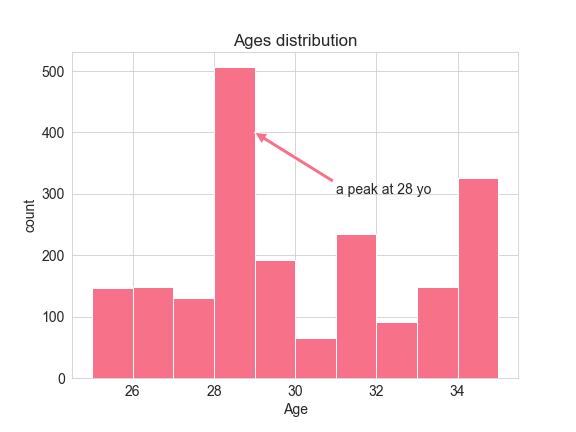

In [56]:
# plot first visualization of single variable "Age" (histogram)
df_age_income = df[['Age', 'AnnualIncome', 'GraduateOrNot']]
fig, ax = plt.subplots(figsize=(8,6))  # figsize=(12, 4) useless
df_age_income['Age'].plot.hist(ax=ax, title='Ages distribution')  # height=6, aspect=2
ax.set(xlabel='Age', ylabel='count')
ax.annotate("a peak at 28 yo", xy=(29,400), xytext=(31, 300), arrowprops={})
plt.close()
text = '\
    <font size="+2">Ages distribution histogram view :\
    <li>Flyers are of <span style="color:DarkBlue "> all ages </span> (peak at 28 years-old)'
add_split_screen(fig, text, iwidth='500px')


,Annual Income boxplot view : a quite large IQR representing big diversity in wages first quartile on left-hand side = 600000.0 third quartile on right-hand side = 1250000.0

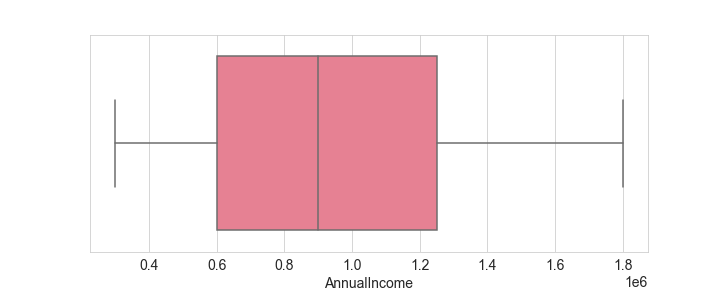

In [57]:
# plot second visualization of single variable "income" (boxplot)
fig, ax = plt.subplots(figsize=(10, 4))  # figsize=(12, 4) useless
ax = sns.boxplot(data=df_age_income, x='AnnualIncome')  # height=6, aspect=2
#title='Income variation'
plt.close()
text = '\
    <font size="+2">Annual Income boxplot view :\
    <br>a quite<span style="color:DarkBlue "> large IQR </span> representing big diversity in wages\
    <li><span style="color:DarkBlue "> first quartile </span> on left-hand side = {}\
    <li><span style="color:DarkBlue "> third quartile </span> on right-hand side = {}'\
        .format(np.quantile(df_age_income.AnnualIncome, 0.25), np.quantile(df_age_income.AnnualIncome, 0.75))
add_split_screen(fig, text, iwidth='500px')

In [58]:
df2 = df
mapping_cust = {True:'current customer', False:'prospect'}
df2['TravelInsurance'] = df['TravelInsurance'].replace(mapping_cust).astype('category')
df2.head(3)

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance,Private_employer
0,31,Government Sector,True,400000,6,True,False,False,prospect,False
1,31,Private Sector/Self Employed,True,1250000,7,False,False,False,prospect,True
2,34,Private Sector/Self Employed,True,500000,4,True,False,False,current customer,True


In [59]:
df2.columns

Index(['Age', 'Employment Type', 'GraduateOrNot', 'AnnualIncome',
       'FamilyMembers', 'ChronicDiseases', 'FrequentFlyer',
       'EverTravelledAbroad', 'TravelInsurance', 'Private_employer'],
      dtype='object')

## 4. Q1:Differences between customers and non-customers' travel habits

Travel habits are defined with two parameters :
<li><span style='color:DarkBlue '> Frequency </span> of flights from the traveller
<li>Whether traveller did travelled <span style='color:DarkBlue '> abroad </span>

In [60]:
df2['TravelInsurance'].value_counts()

prospect            1277
current customer     710
Name: TravelInsurance, dtype: int64

In [61]:
df_freq = df2.groupby(['TravelInsurance', 'Employment Type', 'FrequentFlyer'])['Age'].count().reset_index().rename(columns={'TravelInsurance':'Flyer segment'})
df_freq['Prop% to flyer segment'] = 100 * df_freq['Age'] / df_freq.groupby('Flyer segment')['Age'].transform('sum')
df_freq = df_freq.rename(columns = {'FrequentFlyer':'Frequent'})
df_freq

,Flyer segment,Employment Type,Frequent,Age,Prop% to flyer segment
0,current customer,Government Sector,False,106,14.929577
1,current customer,Government Sector,True,34,4.788732
2,current customer,Private Sector/Self Employed,False,365,51.408451
3,current customer,Private Sector/Self Employed,True,205,28.873239
4,prospect,Government Sector,False,397,31.088489
5,prospect,Government Sector,True,33,2.584182
6,prospect,Private Sector/Self Employed,False,702,54.972592
7,prospect,Private Sector/Self Employed,True,145,11.354738


### Flyers' frequency of flights

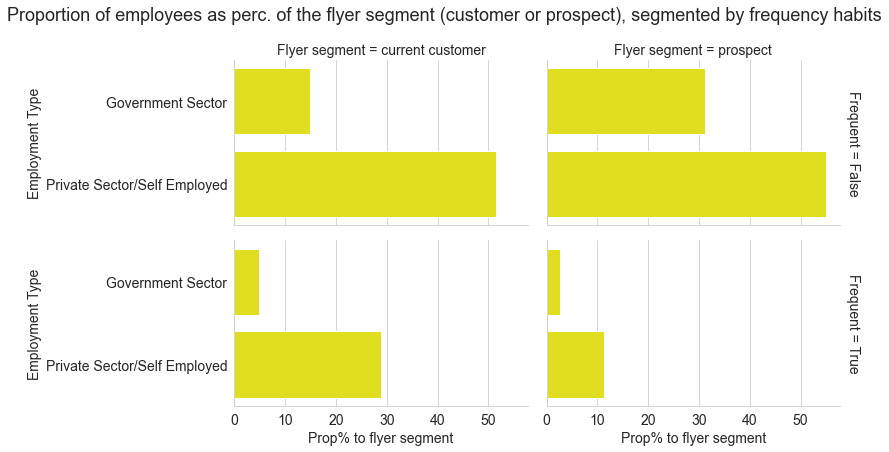

In [62]:
g = sns.FacetGrid(data=df_freq, col='Flyer segment', row='Frequent', height=3, aspect=2, margin_titles=True)  # df2[df2.TravelInsurance=='prospect']
g.map(sns.barplot, 'Prop% to flyer segment', 'Employment Type', color='Yellow', order=None)  #x='Employment Type'
g.fig.suptitle('Proportion of employees as perc. of the flyer segment (customer or prospect), segmented by frequency habits', fontsize=18, y=1.05)
plt.show()

<li>66% of current customers, whereas 86% of prospected customers, are occasional flyers
<li>the proportion of <span style='color:DarkBlue '> private sector </span> employees is much higher in any cases

In [63]:
df_abroad = df2.groupby(['TravelInsurance', 'Employment Type', 'EverTravelledAbroad'])['Age'].count().reset_index().rename(columns={'TravelInsurance':'Flyer segment'})
df_abroad['Prop% to flyer segment'] = 100 * df_abroad['Age'] / df_abroad.groupby('Flyer segment')['Age'].transform('sum')
df_abroad = df_abroad.rename(columns = {'EverTravelledAbroad':'Trav. abroad'})
df_abroad

,Flyer segment,Employment Type,Trav. abroad,Age,Prop% to flyer segment
0,current customer,Government Sector,False,114,16.056338
1,current customer,Government Sector,True,26,3.661972
2,current customer,Private Sector/Self Employed,False,298,41.971831
3,current customer,Private Sector/Self Employed,True,272,38.309859
4,prospect,Government Sector,False,411,32.184808
5,prospect,Government Sector,True,19,1.487862
6,prospect,Private Sector/Self Employed,False,784,61.393892
7,prospect,Private Sector/Self Employed,True,63,4.933438


### Flyers' international-flights habits

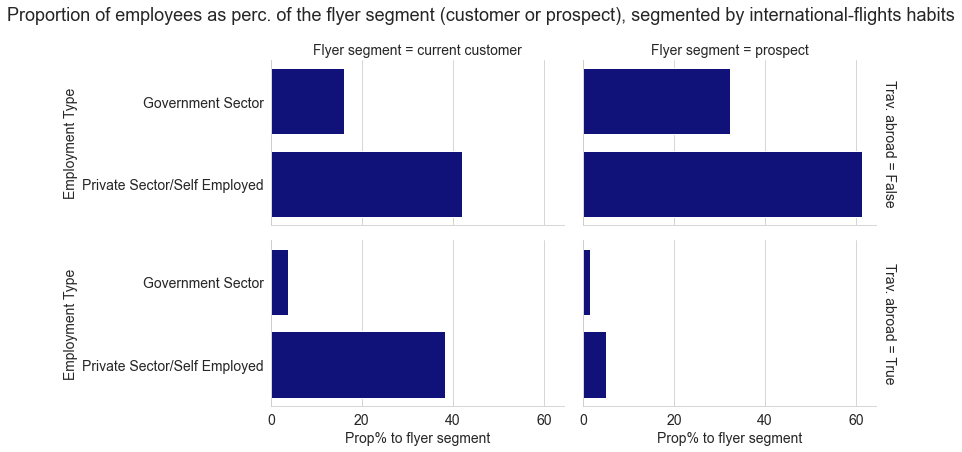

In [64]:
g = sns.FacetGrid(data=df_abroad, col='Flyer segment', row='Trav. abroad', height=3, aspect=2, margin_titles=True)  # df2[df2.TravelInsurance=='prospect']
g.map(sns.barplot, 'Prop% to flyer segment', 'Employment Type', color='DarkBlue', order=None)  #x='Employment Type'
g.fig.suptitle('Proportion of employees as perc. of the flyer segment (customer or prospect), segmented by international-flights habits', fontsize=18, y=1.05)
plt.show()

the difference in habits for international flights is even more flagrant :
<li>58% of current customers, whereas almost all (93%) prospected customers, are <span style='color:DarkBlue '> domestic flyers </span>
<li>just like in frequency habits, the proportion of <span style='color:DarkBlue '> private sector </span> employees is much higher in any cases

## 5. Q2:Typical profile of customers and non-customers

Typical profile split :<br>
<li><span style='color:DarkBlue '> Personal </span> features : Age, family-size, health-disease
<li><span style='color:DarkBlue '> Professional </span> features : Employment Type, Graduation-level, Level of revenue
<li>For further better data interpretation, data has been <span style='color:DarkBlue '> grouped into categories </span>

Reminder :<br>
<p>Largest positive correlations:<br>
AnnualIncome :  0.486 EverTravelledAbroad<br>
FrequentFlyer :  0.353 AnnualIncome<br>
EverTravelledAbroad :  0.486 AnnualIncome<br>
TravelInsurance :  0.433 EverTravelledAbroad<br>
Private_employer :  0.349 AnnualIncome</p>

### Ordering personal features

In [65]:
# ordering dataframe by Age
df2 = df2.sort_values('Age')
df2.head()

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance,Private_employer
1456,25,Private Sector/Self Employed,False,1700000,3,False,True,False,current customer,True
1244,25,Private Sector/Self Employed,False,1150000,3,True,False,True,prospect,True
595,25,Private Sector/Self Employed,False,1150000,5,True,True,False,prospect,True
592,25,Private Sector/Self Employed,True,1700000,4,False,True,False,current customer,True
1013,25,Private Sector/Self Employed,False,600000,4,False,True,False,prospect,True


In [66]:
df_young = df2[df2.Age < 29]
df_old = df2[df2.Age >= 29]

df_young = df_young.assign(Age_category = 'below 29yo')
df_old = df_old.assign(Age_category = 'above 29yo')

df3 = pd.concat([df_young, df_old], axis=0)
df3['Age_category'] = pd.Categorical(df3['Age_category'], categories=['below 29yo', 'above 29yo'], ordered=True)
df3.Age_category.head()

1456    below 29yo
1244    below 29yo
595     below 29yo
592     below 29yo
1013    below 29yo
Name: Age_category, dtype: category
Categories (2, object): ['below 29yo' < 'above 29yo']

In [67]:
#bucket family-size in 3 categories : couple or small single-parent-family (2), small-to-medium-family (3), bigger family (4 to ?)
mapping_family ={2:'Couple', 3:'Small_Mid', 4:'Small_Mid', 5:'Big', 6:'Big', 7:'Big', 8:'Big', 9:'Big'}
df3['family_type'] = df3['FamilyMembers'].replace(mapping_family).astype('category')
df3['family_type'] = df3['family_type'].cat.set_categories(
    new_categories=['Couple', 'Small_Mid', 'Big'],
    ordered=True
)
df3.family_type.head()

1456    Small_Mid
1244    Small_Mid
595           Big
592     Small_Mid
1013    Small_Mid
Name: family_type, dtype: category
Categories (3, object): ['Couple' < 'Small_Mid' < 'Big']

In [68]:
#Chronic-desease : alreadybinary

### Ordering professional features

In [69]:
#bucket revenue in 2: < 900k and >900k (900k is the median)
df_poor = df3[df3.AnnualIncome < 900000]
df_rich = df3[df3.AnnualIncome >= 900000]

df_poor = df_poor.assign(Revenue_category = 'below 900k')
df_rich = df_rich.assign(Revenue_category = 'above 900k')

df4 = pd.concat([df_poor, df_rich], axis=0)
df4['Revenue_category'] = pd.Categorical(df4['Revenue_category'], categories=['below 900k', 'above 900k'], ordered=True)
print(df4.Revenue_category.head())
df4.Revenue_category.value_counts()

1013    below 900k
1399    below 900k
397     below 900k
629     below 900k
1759    below 900k
Name: Revenue_category, dtype: category
Categories (2, object): ['below 900k' < 'above 900k']


above 900k    1044
below 900k     943
Name: Revenue_category, dtype: int64

In [70]:
# split dataset in 
# 1/ customers
# 2/ non-customers = prospects

customers = df4[df4.TravelInsurance == 'current customer']
prospects = df4[df4.TravelInsurance == 'prospect']

display(customers.head(1))
display(prospects.head(1))

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance,Private_employer,Age_category,family_type,Revenue_category
1457,25,Private Sector/Self Employed,False,600000,3,False,False,False,current customer,True,below 29yo,Small_Mid,below 900k


,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance,Private_employer,Age_category,family_type,Revenue_category
1013,25,Private Sector/Self Employed,False,600000,4,False,True,False,prospect,True,below 29yo,Small_Mid,below 900k


In [71]:
# observe results
for c in customers.columns:
    print('\n', customers[c].value_counts(normalize=True))


 34    0.187324
28    0.147887
25    0.129577
33    0.109859
31    0.105634
26    0.104225
29    0.071831
30    0.039437
35    0.039437
27    0.038028
32    0.026761
Name: Age, dtype: float64

 Private Sector/Self Employed    0.802817
Government Sector               0.197183
Name: Employment Type, dtype: float64

 True     0.860563
False    0.139437
Name: GraduateOrNot, dtype: float64

 1400000    0.167606
1500000    0.111268
800000     0.057746
1350000    0.057746
500000     0.049296
1300000    0.049296
1700000    0.046479
1450000    0.043662
700000     0.042254
1100000    0.039437
1200000    0.036620
1050000    0.036620
550000     0.032394
600000     0.026761
1000000    0.026761
900000     0.022535
1250000    0.018310
850000     0.018310
750000     0.018310
1150000    0.018310
650000     0.015493
400000     0.014085
300000     0.008451
950000     0.008451
1550000    0.007042
450000     0.007042
1750000    0.005634
1800000    0.005634
350000     0.005634
1650000    0.002817
Name: Ann

In [72]:
customers_personal = customers[['Age_category', 'family_type', 'ChronicDiseases']]
prospects_personal = prospects[['Age_category', 'family_type', 'ChronicDiseases']]
customers_professional = customers[['Employment Type', 'GraduateOrNot', 'Revenue_category']]
prospects_professional = prospects[['Employment Type', 'GraduateOrNot', 'Revenue_category']]

### Personal profiles

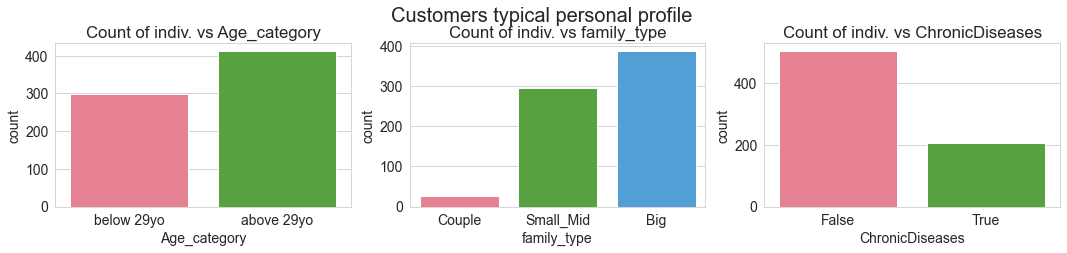

In [73]:
# plot customers personal features
fig, axs = plt.subplots(1, 3, figsize=(18,3))  # was 18,6

for i, c in enumerate(customers_personal.columns):
    #print(i+1, c)
    dfc = customers[c].to_frame()
    sns.countplot(data=dfc, x=dfc.columns[0], ax=axs[i])
    axs[i].set_title('Count of indiv. vs ' + c)
fig.suptitle('Customers typical personal profile', fontsize=20, y=1.05)
plt.show()

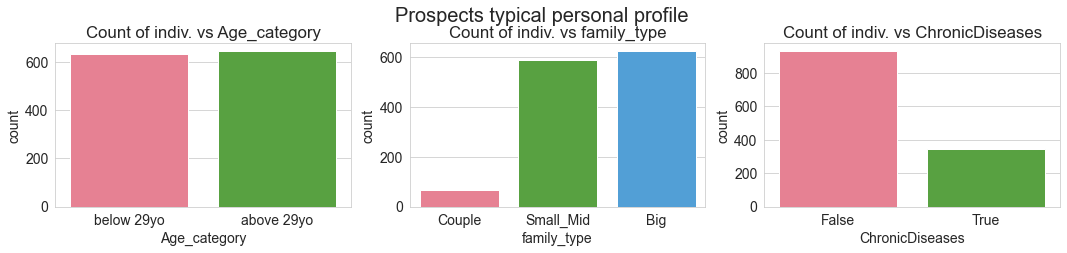

In [74]:
# plot prospects personal features
fig, axs = plt.subplots(1, 3, figsize=(18,3))

for i, c in enumerate(prospects_personal.columns):
    #print(i+1, c)
    dfc = prospects[c].to_frame()
    sns.countplot(data=dfc, x=dfc.columns[0], ax=axs[i])
    axs[i].set_title('Count of indiv. vs ' + c)
fig.suptitle('Prospects typical personal profile', fontsize=20, y=1.05)
plt.show()

<li>Prospects : larger proportion of <span style='color:DarkBlue '> younger people</span> with <span style='color:DarkBlue '> less diseases</span>

### Professional profiles

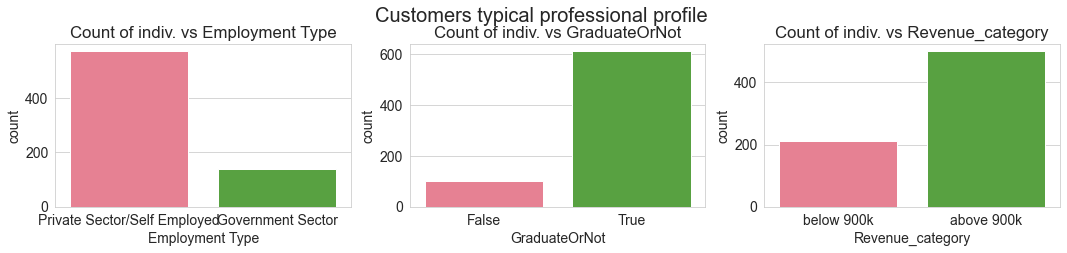

In [75]:
# plot customers professional features
fig, axs = plt.subplots(1, 3, figsize=(18,3))

for i, c in enumerate(customers_professional.columns):
    #print(i+1, c)
    dfc = customers[c].to_frame()
    sns.countplot(data=dfc, x=dfc.columns[0], ax=axs[i])
    axs[i].set_title('Count of indiv. vs ' + c)
fig.suptitle('Customers typical professional profile', fontsize=20, y=1.05)
plt.show()

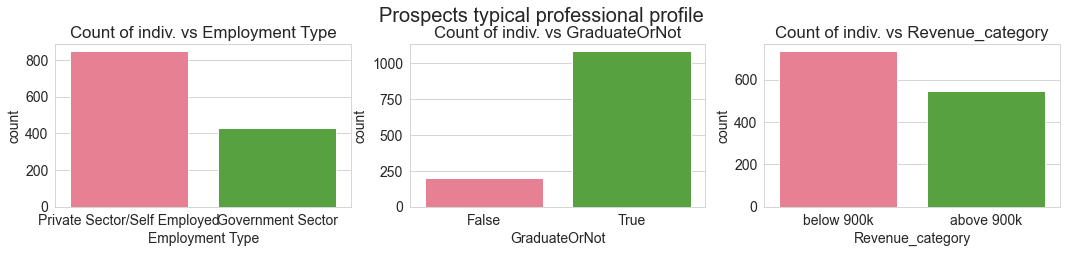

In [76]:
# plot prospects professional features
fig, axs = plt.subplots(1, 3, figsize=(18,3))

for i, c in enumerate(prospects_professional.columns):
    #print(i+1, c)
    dfc = prospects[c].to_frame()
    sns.countplot(data=dfc, x=dfc.columns[0], ax=axs[i])
    axs[i].set_title('Count of indiv. vs ' + c)
fig.suptitle('Prospects typical professional profile', fontsize=20, y=1.05)
plt.show()

<li>Prospects : larger proportion in <span style='color:DarkBlue '> Government Sector or Revenues below 900k</span> than in Private Sector

In [77]:
pivoted = df4.pivot_table(values='Age', index=['Employment Type', 'Revenue_category'], columns='TravelInsurance', aggfunc='count', margins=True, margins_name='grandtotal')
pivoted2 = pivoted.assign(prosp_perc = lambda pivoted2: round(pivoted.prospect/pivoted.grandtotal*100, 1))
pivoted2

TravelInsurance                                current customer  prospect  \
Employment Type              Revenue_category                               
Government Sector            below 900k                      71       321   
                             above 900k                      69       109   
Private Sector/Self Employed below 900k                     139       412   
                             above 900k                     431       435   
grandtotal                                                  710      1277   

TravelInsurance                                grandtotal  prosp_perc  
Employment Type              Revenue_category                          
Government Sector            below 900k               392        81.9  
                             above 900k               178        61.2  
Private Sector/Self Employed below 900k               551        74.8  
                             above 900k               866        50.2  
grandtotal                                           1987        64.3

In [78]:
pivoted = df4.pivot_table(values='Age', index=['FrequentFlyer', 'EverTravelledAbroad'], columns='TravelInsurance', aggfunc='count', margins=True, margins_name='grandtotal')
pivoted2 = pivoted.assign(prosp_perc = lambda pivoted2: round(pivoted.prospect/pivoted.grandtotal*100, 1))
pivoted2

TravelInsurance                    current customer  prospect  grandtotal  \
FrequentFlyer EverTravelledAbroad                                           
False         False                             321      1037        1358   
              True                              150        62         212   
True          False                              91       158         249   
              True                              148        20         168   
grandtotal                                      710      1277        1987   

TravelInsurance                    prosp_perc  
FrequentFlyer EverTravelledAbroad              
False         False                      76.4  
              True                       29.2  
True          False                      63.5  
              True                       11.9  
grandtotal                               64.3

According to figures :
<li><span style='color:DarkBlue '> Government sector </span> and <span style='color:DarkBlue '> low-revenue </span> categories clear show better development opportunities
<li><span style='color:DarkBlue '> Occasional </span> and <span style='color:DarkBlue '> domestic flyers </span> are of particular concern

## 6. Conclusion and recommendations

The initial questions of marketing team were :
<li>Are there differences in travel habits between customers and non-customers?
<li>What is the typical profile of customers and non-customers?</li>

There is a very large proportion of prospects who <span style='color:DarkBlue '> never travelled abroad </span>.<br>
They are mainly <span style='color:DarkBlue '> intermittent flyers </span>.
Our recommandation is to focus our advertising plan on :
1. <span style='color:DarkBlue '> domestic travellers </span> travellers
2. <span style='color:DarkBlue '> unfrequent </span> travellers

Basic international policies, like emergency medical expenses while overseas, should not of immediate concern to focus on. <br>Anyway <span style='color:DarkBlue '> comprehensive-policies </span> such as trip cancellation, lost luggage or maybe flight delays coverage are more <span style='color:DarkBlue '> suspected to be of interest </span> for our prospect-flyers.

Typical profiles of prospects are <span style='color:DarkBlue '> graduated invividuals with revenues < 900k </span>, working in Private sector or self-employed.
Big-revenues-flyers seem to get already engaged into our programs.

### Further proposal
It could be interesting to mix those flying habits and profiles to priorize business-development actions.
Another interesting input could be if flights are for private or professional use, in order to adapt policies.

# THANK YOU !